<a href="https://colab.research.google.com/github/lorenzosquadrani/RobertasTree/blob/main/try_robbistree_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install packages

In [1]:
! git clone https://github.com/lorenzosquadrani/RobertasTree.git --quiet

In [2]:
 cd RobertasTree/

/content/RobertasTree


In [3]:
!python -m pip install -r requirements.txt --quiet

In [4]:
!python setup.py develop --user

running develop
running egg_info
creating robertastree.egg-info
writing robertastree.egg-info/PKG-INFO
writing dependency_links to robertastree.egg-info/dependency_links.txt
writing requirements to robertastree.egg-info/requires.txt
writing top-level names to robertastree.egg-info/top_level.txt
writing manifest file 'robertastree.egg-info/SOURCES.txt'
writing manifest file 'robertastree.egg-info/SOURCES.txt'
running build_ext
Creating /root/.local/lib/python3.7/site-packages/robertastree.egg-link (link to .)
Adding robertastree 0.1.0 to easy-install.pth file

Installed /content/RobertasTree
Processing dependencies for robertastree==0.1.0
Searching for torch==1.9.0+cu102
Best match: torch 1.9.0+cu102
Adding torch 1.9.0+cu102 to easy-install.pth file
Installing convert-caffe2-to-onnx script to /root/.local/bin
Installing convert-onnx-to-caffe2 script to /root/.local/bin

Using /usr/local/lib/python3.7/dist-packages
Searching for pandas==1.1.5
Best match: pandas 1.1.5
Adding pandas 1.1.5 

# RobertasTree on MNIST

## Prepare dataset

In [5]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
y = y.astype('int')

In [6]:
X = X[y < 8]
y = y[y < 8]

In [7]:
import pandas as pd
import numpy as np

dataset = pd.DataFrame(X)
dataset['label'] = pd.Series(y.astype('int'))

In [8]:
from sklearn.model_selection import train_test_split
train_valid_set, testset = train_test_split(dataset, test_size=0.2,random_state=42)
trainset, validset = train_test_split(train_valid_set, test_size=0.2, random_state=42)

## Pytorch classifier

In [9]:
import torch

class SimpleClassifier(torch.nn.Module):
    def __init__(self, num_classes):
        super(SimpleClassifier, self).__init__()
        
        self.linear1 = torch.nn.Linear(784, 16)
        self.linear2 = torch.nn.Linear(16, num_classes)

        self.dropout = torch.nn.Dropout(0.1)
        self.relu = torch.nn.ReLU()

        
    def forward(self, x):
        
        out = self.relu(self.linear1(x))
        out = self.linear2(self.dropout(out))

        return out

In [10]:
classifier = SimpleClassifier(num_classes=2)

## Build the tree

In [11]:
!mkdir ../data

In [12]:
from robertastree.model import Tree

tree = Tree(classifier=classifier,
            trainset=trainset,
            validset=validset,
            models_path = '../data')

Found GPU Tesla K80. I will use it.


In [13]:
from torch.utils.data import Dataset

class SimpleDataset(Dataset):
    def __init__(self, dataframe):
        super(SimpleDataset,self).__init__()

        self.inputs = dataframe.drop(['label',], axis=1)
        self.labels = dataframe.label

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):

        sample = torch.tensor(self.inputs.iloc[idx].values, dtype = torch.float)
        label = torch.tensor(self.labels.iloc[idx], dtype = torch.long)

        return {'x':sample}, label


In [14]:
tree.configure(optimizer= torch.optim.SGD,
               optimizer_params={'lr':2e-3,
                                'weight_decay':1e-4},
               loss_function=torch.nn.CrossEntropyLoss(),
               dataset_class=SimpleDataset,
               batch_size=128,
               num_epochs=100,
               scheduler=torch.optim.lr_scheduler.MultiStepLR,
               scheduler_params={'milestones':(70,), 'gamma':0.1},
               valid_period=100  #very big value, to validate only at the beginning of each epoch
            ) 

In [15]:
tree.train()

========== Training classifier [0,0] ==========
[epoch, batch/num_batches]: trainloss | validloss | best_validloss | accuracy
[   0,  100/ 282]: 1.1863 | 0.2466 | 89.84% |   inf
[   0,  200/ 282]: 0.7168 | 0.1909 | 91.83% | 0.2466
[   1,   18/ 282]: 0.2236 | 0.1659 | 93.39% | 0.1909
[   1,  118/ 282]: 0.2046 | 0.1529 | 94.33% | 0.1659
[   1,  218/ 282]: 0.1981 | 0.1482 | 94.50% | 0.1529
[   2,   36/ 282]: 0.1683 | 0.1310 | 95.15% | 0.1482
[   2,  136/ 282]: 0.1748 | 0.1265 | 95.38% | 0.1310
[   2,  236/ 282]: 0.1736 | 0.1272 | 95.56% | 0.1265
[   3,   54/ 282]: 0.1577 | 0.1215 | 95.69% | 0.1265
[   3,  154/ 282]: 0.1615 | 0.1185 | 95.64% | 0.1215
[   3,  254/ 282]: 0.1597 | 0.1163 | 95.82% | 0.1185
[   4,   72/ 282]: 0.1495 | 0.1111 | 96.12% | 0.1163
[   4,  172/ 282]: 0.1492 | 0.1109 | 96.21% | 0.1111
[   4,  272/ 282]: 0.1477 | 0.1025 | 96.50% | 0.1109
[   5,   90/ 282]: 0.1411 | 0.0992 | 96.55% | 0.1025
[   5,  190/ 282]: 0.1407 | 0.0971 | 96.66% | 0.0992
[   6,    8/ 282]: 0.1185 |

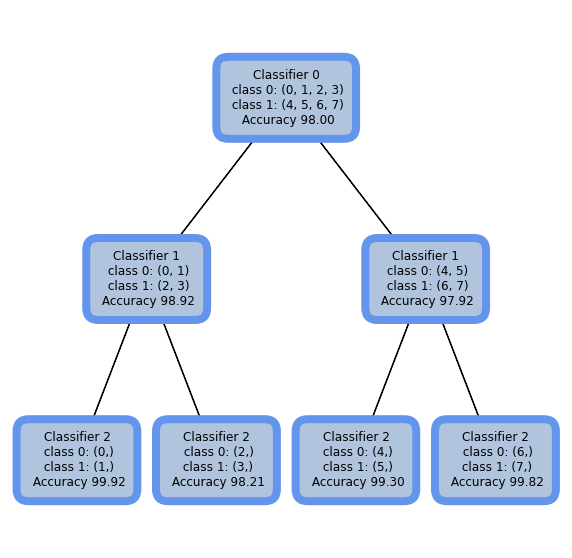

In [16]:
fig = tree.plot_tree()
fig.show()

## Test

In [17]:
dataloader = torch.utils.data.DataLoader(SimpleDataset(testset), batch_size=256)

In [18]:
right = 0
total = 0

for inputs, labels in dataloader:

    for key in inputs:
        inputs[key] = inputs[key].to(tree.device)

    labels = labels.to(tree.device)

    y_pred = tree.predict(inputs, return_probabilities=True)

    right += (y_pred.argmax(axis=1)==labels).sum()
    total += len(labels)

print("ACCURACY: {:.2%}".format(right/total))

ACCURACY: 93.85%


# Classifier on its own

## Set training

In [ ]:
from torch.utils.data import DataLoader

classifier = SimpleClassifier(num_classes = 8).to('cuda')

optimizer = torch.optim.SGD(classifier.parameters(), lr=2e-3)

trainloader = DataLoader(SimpleDataset(trainset), batch_size=128, shuffle=True)
validloader = DataLoader(SimpleDataset(validset), batch_size=256)

loss_function = torch.nn.CrossEntropyLoss()

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, (100,150), 0.1)

## Train

In [ ]:
global_step = 0

for epoch in range(200):

    print("EPOCH [{}]".format(epoch))

    train_loss = 0.
    epoch_step = 0

    for samples, labels in trainloader:

        for key in samples:
            samples[key] = samples[key].to('cuda')

        labels = labels.to('cuda')

        y_pred = classifier(**samples)

        loss = loss_function(y_pred, labels)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()
        global_step += 1
        epoch_step += 1

        # Validation loop. Save progress and evaluate model performance.
        if (global_step % 100 == 0) and (validloader is not None):

            classifier.eval()

            right = 0
            total = 0
            loss = 0.

            with torch.no_grad():

                for samples, labels in validloader:

                    for key in samples:
                        samples[key] = samples[key].to('cuda')

                    labels = labels.to('cuda')

                    y_pred = classifier(**samples)

                    loss_ = loss_function(y_pred, labels)
                    loss += loss_.item()

                    total += len(labels)
                    right += (y_pred.argmax(axis=-1) == labels).sum().item()

                    valid_loss = loss / len(validloader)
                    accuracy = right / total * 100
            
            classifier.train()
            # print summary
            print('Step: [{}/{}], train_loss: {:.4f}, valid_loss: {:.4f}, accuracy: {:.2f} %'
                    .format(epoch_step,
                            len(trainloader),
                            train_loss / epoch_step, valid_loss, accuracy))
    
    scheduler.step()

EPOCH [0]
Step: [100/282], train_loss: 2.3236, valid_loss: 1.7777, accuracy: 29.47 %
Step: [200/282], train_loss: 2.0243, valid_loss: 1.5814, accuracy: 36.31 %
EPOCH [1]
Step: [18/282], train_loss: 1.3582, valid_loss: 1.2639, accuracy: 48.00 %
Step: [118/282], train_loss: 1.3245, valid_loss: 1.1882, accuracy: 51.92 %
Step: [218/282], train_loss: 1.3036, valid_loss: 1.1301, accuracy: 50.62 %
EPOCH [2]
Step: [36/282], train_loss: 1.2197, valid_loss: 1.1041, accuracy: 53.00 %
Step: [136/282], train_loss: 1.2328, valid_loss: 1.0804, accuracy: 52.92 %
Step: [236/282], train_loss: 1.2175, valid_loss: 1.0645, accuracy: 53.00 %
EPOCH [3]
Step: [54/282], train_loss: 1.1128, valid_loss: 1.0072, accuracy: 60.58 %
Step: [154/282], train_loss: 1.0989, valid_loss: 0.9567, accuracy: 60.72 %
Step: [254/282], train_loss: 1.0873, valid_loss: 0.9410, accuracy: 60.86 %
EPOCH [4]
Step: [72/282], train_loss: 1.1074, valid_loss: 0.9204, accuracy: 60.97 %
Step: [172/282], train_loss: 1.0651, valid_loss: 0.916

## Test

In [ ]:
testloader = DataLoader(SimpleDataset(testset), batch_size=256)

right = 0
total = 0

with torch.no_grad():
    for samples, labels in testloader:

        for key in samples:
            samples[key] = samples[key].to('cuda')

        labels = labels.to('cuda')

        y_pred = classifier(**samples)

        total += len(labels)
        right += (y_pred.argmax(axis=-1) == labels).sum().item()

    accuracy = right / total

In [ ]:
print("ACCURACY: {:.2%}".format(accuracy))

ACCURACY: 87.60%
